In [22]:
import os
import sys


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse, smape
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.timeseries_generation import holidays_timeseries

# ------------------------------------------------------------
# 0) 변수 설정
# ------------------------------------------------------------

# 경로 
train_path = "DATA/train.csv"
test_path = "DATA/test.csv"

# 건물번호
building_num = 1

# 타겟 컬럼
target_col = "전력소비량(kWh)"
col_names = ["building_num", "datetime", "temp", "rain", "wind", "humidity", "sun_hr", "sun_mj", "power"]

# 데이터 빈도
FREQ = "h"
INPUT_CHUNK = 168        # 과거 7일 창
OUTPUT_CHUNK = 24        # 24시간 예측
USE_GPU = True

# 모델 파라미터
QUANTILES = [0.1, 0.5, 0.9]
N_EPOCHS = 50
BATCH_SIZE = 64


In [29]:
# ------------------------------------------------------------
# 1) 기본 유틸리티 함수
# ------------------------------------------------------------

def load_data(file_path: str):
    df = pd.read_csv(file_path, header=0, index_col=0)
    return df


def split_by_building(df: pd.DataFrame, building_num: int):
    if "건물번호" not in df.columns:
        return df[df['building_num'] == building_num]
    return df[df['건물번호'] == building_num]


def change_col_name(df: pd.DataFrame, col_names: list[str]=None):
    if col_names is None: # 일조, 일사 추가
        col_names = ["building_num", "datetime", "temp", "rain", "wind", "humidity", "sun_hr", "sun_mj", "power"]
    df.columns = col_names
    return df


def plot_data(df: pd.DataFrame, target_col: str, building_num: int):
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.figure(figsize=(15, 5))
    df[target_col].plot(title=f"건물번호 {building_num} - {target_col}")
    plt.show()


# ------------------------------------------------------------
# 2) Darts 유틸리티 함수
# ------------------------------------------------------------

def to_timeseries(df: pd.DataFrame, target_cols: list[str], time_col: str, freq: str = "h") -> TimeSeries:
    """
    df를 TimeSeries로 변환
    """
    ts = TimeSeries.from_dataframe(
        df.sort_values(time_col), 
        time_col=time_col,
        value_cols=target_cols,
        freq=freq
    )
    return ts

# Test Code
df = load_data("DATA/train.csv")
df_cols = df.columns.tolist(); print(df_cols)
df_01 = split_by_building(df, 1)
df_01 = change_col_name(df_01); print(df_01.columns)

# print(df_01.head())
ts = to_timeseries(
    df = df_01, 
    target_cols = ['power'],
    time_col = "datetime", 
    freq = "h"
)
ts

['건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
Index(['building_num', 'datetime', 'temp', 'rain', 'wind', 'humidity',
       'sun_hr', 'sun_mj', 'power'],
      dtype='object')


<TimeSeries (datetime: 2040, component: 1, sample: 1)> Size: 16kB
array([[[5794.8 ]],

       [[5591.85]],

       [[5338.17]],

       ...,

       [[4135.86]],

       [[4571.97]],

       [[4499.01]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 16kB 2024-06-01 ... 2024-08-24T23:00:00
  * component  (component) object 8B 'power'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [ ]:
# 빠른 Darts 테스트 : 예측
assert "datetime" in df_01.columns and "power" in df_01.columns

series = to_timeseries(df_01, target_cols="power", time_col="datetime")


likelihood = QuantileRegression(quantiles=QUANTILES)
model = TFTModel(
    input_chunk_length=INPUT_CHUNK,
    output_chunk_length=OUTPUT_CHUNK,
    hidden_size=64,
    lstm_layers=2,
    dropout=0.1,
    num_attention_heads=4,
    add_relative_index=True,
    likelihood=likelihood,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    random_state=42,
)
try:
    import torch
    torch.backends.cudnn.conv.fp32_precision = "tf32" # 메모리 소비 감소
    torch.backends.cuda.matmul.fp32_precision = "high" # 성능 향상
    # 또는 정확도를 우선하면:
    # torch.backends.cudnn.conv.fp32_precision = "ieee"
    # torch.backends.cuda.matmul.fp32_precision = "ieee"
except Exception as e:
    print(e)

model.fit(series)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/user/Dacon_elec_0825/src/data_with_darts/.venv/lib/python3.11/site-packages/torch/__init__.py:1539: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA GeForce RTX 5070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-of

Epoch 49: 100%|██████████| 29/29 [00:03<00:00,  8.34it/s, train_loss=7.28e+3]       

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 29/29 [00:03<00:00,  8.34it/s, train_loss=7.28e+3]


TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=2, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=QuantileRegression(quantiles=[0.1, 0.5, 0.9], prior_strength=1.0), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=168, output_chunk_length=24, batch_size=64, n_epochs=50, random_state=42)

In [36]:
fc_serve_sc = model.predict(
    n=24,
    series=series,
    num_samples=100
)
fc_serve_sc

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


<TimeSeries (datetime: 24, component: 1, sample: 100)> Size: 19kB
array([[[686.31756099, 688.39827297, 676.04378202, ..., 672.3241768 ,
         689.36372799, 686.42136548]],

       [[673.60360494, 673.15030558, 673.43555868, ..., 673.60360494,
         673.54981415, 686.05974295]],

       [[689.14883583, 672.45884637, 672.39133294, ..., 689.36414086,
         675.26255775, 673.05988196]],

       ...,

       [[678.06954897, 672.45566815, 682.62631625, ..., 673.60496171,
         680.35378767, 673.60496171]],

       [[689.3641422 , 673.40017503, 685.19885883, ..., 673.3765485 ,
         686.88657033, 673.3636665 ]],

       [[672.84945528, 672.90675588, 676.38606453, ..., 678.12225908,
         672.27574339, 673.13534834]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 192B 2024-08-25 ... 2024-08-25T23:00:00
  * component  (component) object 8B 'power'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [38]:
fc_serve = fc_serve_sc
print("Serve forecast window:", fc_serve.start_time(), "->", fc_serve.end_time())
print("Serve P50 last:", fc_serve.values()[-1, 0])

Serve forecast window: 2024-08-25 00:00:00 -> 2024-08-25 23:00:00
Serve P50 last: 672.849455276511


## 운영 팁

데이터 검증: 인덱스 중복/결측, 빈도 불일치, 타깃 음수/비정상값 제거.

공변량 분리 원칙:

past_covariates: 예측 시점 이전에 관측된 값만(실측 기상, 랙/롤링 가능).

future_covariates: 예측 창 전 구간에서 이미 알고 있는 값(캘린더, 예보).

빈도 변경 시: INPUT_CHUNK/OUTPUT_CHUNK, forecast_horizon, stride만 조정.

조기 종료: pl.Trainer 인자나 n_epochs 축소, 또는 Darts의 pl_trainer_kwargs 사용.

다중 시계열: 여러 지역/고객군을 리스트로 전달하면 글로벌 모델 학습 가능.

해석: TFT의 변수/시간 중요도 추출 기능을 테스트 단계에서 활용.

Hello from data-with-darts!
               건물번호           일시  기온(°C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
num_date_time                                                               
1_20240601 00     1  20240601 00    18.3      0.0      2.6   82.0     0.0   
1_20240601 01     1  20240601 01    18.3      0.0      2.7   82.0     0.0   
1_20240601 02     1  20240601 02    18.1      0.0      2.6   80.0     0.0   
1_20240601 03     1  20240601 03    18.0      0.0      2.6   81.0     0.0   
1_20240601 04     1  20240601 04    17.8      0.0      1.3   81.0     0.0   

               일사(MJ/m2)  전력소비량(kWh)  
num_date_time                         
1_20240601 00        0.0     5794.80  
1_20240601 01        0.0     5591.85  
1_20240601 02        0.0     5338.17  
1_20240601 03        0.0     4554.42  
1_20240601 04        0.0     3602.25  


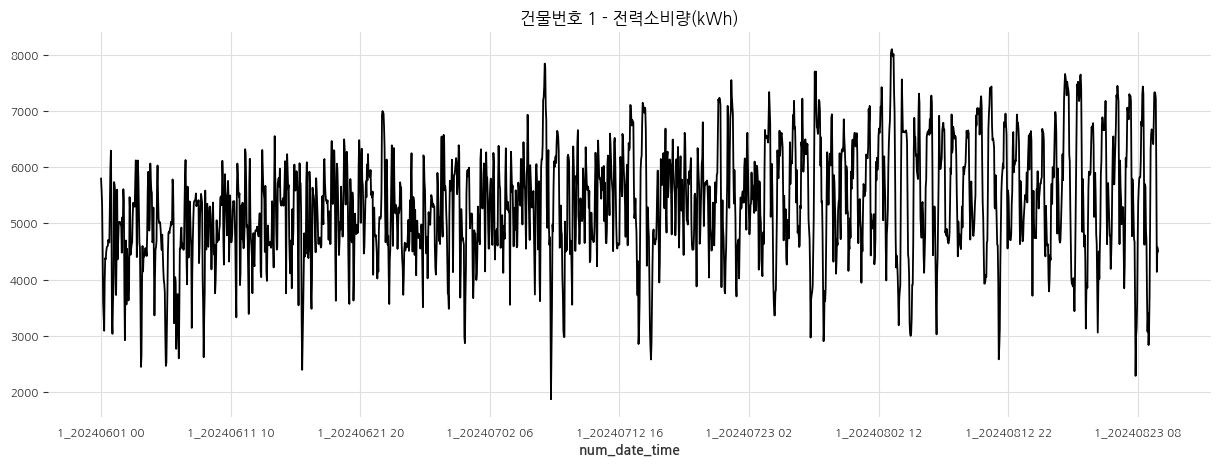

In [39]:


def preprocess_data(df: pd.DataFrame):
    pass


def pipeline_data(df: pd.DataFrame):
    pipeline = Pipeline()
    pass
        


def main():
    print("Hello from data-with-darts!")
    df = load_data("DATA/train.csv")
    df_01 = split_by_building(df, 1)
    print(df_01.head())
    plot_data(df_01, "전력소비량(kWh)", 1)

    preprocess_data(df_01)

main()